# How to add and use subgraphs
**Subgraphs** allow you to build complex systems with multiple components that are themselves graphs. A common use case for using subgraphs is building multi-agent systems.

The main question when adding subgraphs is how the parent graph and subgraph communicate, i.e. how they pass the state between each other during the graph execution. There are two scenarios:

- parent graph and subgraph share schema keys. In this case, you can add a node with the compiled subgraph
- parent graph and subgraph have different schemas. In this case, you have to add a node function that invokes the subgraph: this is useful when the parent graph and the subgraph have different state schemas and you need to transform state before or after calling the subgraph

In [2]:
%%capture --no-stderr
%pip install -U langgraph

## Add a node with the compiled subgraph

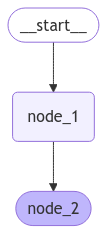

In [1]:
from langgraph.graph import START, StateGraph
from typing import TypedDict
from IPython.display import Image,display


class SubgraphState(TypedDict):
    foo: str
    bar: str


def subgraph_node_1(state: SubgraphState):
    return {"bar": "bar"}


def subgraph_node_2(state: SubgraphState):
    return {"foo": state["foo"] + state["bar"]}


subgraph_builder = StateGraph(SubgraphState)
subgraph_builder.add_node(subgraph_node_1)
subgraph_builder.add_node(subgraph_node_2)
subgraph_builder.add_edge(START, "subgraph_node_1")
subgraph_builder.add_edge("subgraph_node_1", "subgraph_node_2")
subgraph = subgraph_builder.compile()


class ParentState(TypedDict):
    foo: str


def node_1(state: ParentState):
    return {"foo": "hi! " + state["foo"]}


builder = StateGraph(ParentState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", subgraph)
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [2]:
for chunk in graph.stream({"foo": "foo"}):
    print(chunk)

{'node_1': {'foo': 'hi! foo'}}
{'node_2': {'foo': 'hi! foobar'}}


We over-write state, as expected.

In [3]:
for chunk in graph.stream({"foo": "foo"},subgraphs=True):
    print(chunk)

((), {'node_1': {'foo': 'hi! foo'}})
(('node_2:e1d49c71-4b00-68c4-f059-e361af21e82c',), {'subgraph_node_1': {'bar': 'bar'}})
(('node_2:e1d49c71-4b00-68c4-f059-e361af21e82c',), {'subgraph_node_2': {'foo': 'hi! foobar'}})
((), {'node_2': {'foo': 'hi! foobar'}})


## Add a node function that invokes the subgraph

In [4]:

class SubgraphState(TypedDict):
    bar: str
    baz: str


def subgraph_node_1(state: SubgraphState):
    return {"baz": "baz"}


def subgraph_node_2(state: SubgraphState):
    return {"bar": state["bar"] + state["baz"]}


subgraph_builder = StateGraph(SubgraphState)
subgraph_builder.add_node(subgraph_node_1)
subgraph_builder.add_node(subgraph_node_2)
subgraph_builder.add_edge(START, "subgraph_node_1")
subgraph_builder.add_edge("subgraph_node_1", "subgraph_node_2")
subgraph = subgraph_builder.compile()


class ParentState(TypedDict):
    foo: str


def node_1(state: ParentState):
    return {"foo": "hi! " + state["foo"]}


def node_2(state: ParentState):
    response = subgraph.invoke({"bar": state["foo"]})
    return {"foo": response["bar"]}


builder = StateGraph(ParentState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
graph = builder.compile()

In [5]:
for chunk in graph.stream({"foo": "foo"}, subgraphs=True):
    print(chunk)

((), {'node_1': {'foo': 'hi! foo'}})
(('node_2:df31ed6b-9d58-5d2f-b502-fec8b6aa2340',), {'subgraph_node_1': {'baz': 'baz'}})
(('node_2:df31ed6b-9d58-5d2f-b502-fec8b6aa2340',), {'subgraph_node_2': {'bar': 'hi! foobaz'}})
((), {'node_2': {'foo': 'hi! foobaz'}})
